In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import math
import sys

import yfinance as yf
yf.pdr_override()

dataset = pd.read_csv('db/acoes1.csv')
dataset


,Date,VALE3.SA,RECV3.SA,KEPL3.SA,CURY3.SA,VULC3.SA,LEVE3.SA,GGBR4.SA,LREN3.SA,ALSO3.SA,...,CMIG4.SA,ITSA4.SA,BBAS3.SA,TASA4.SA,SLCE3.SA,B3SA3.SA,PETR4.SA,SUZB3.SA,KLBN4.SA,BOVA11.SA
0,2021-05-05,110.709999,15.610000,8.475000,9.85,7.810000,24.430000,32.809525,37.627274,26.660000,...,9.307692,8.839826,29.260000,25.250000,43.818180,17.166666,23.830000,67.669998,5.52,115.150002
1,2021-05-06,115.050003,16.000000,8.896666,9.92,8.020000,24.280001,34.304760,38.018181,27.110001,...,9.223076,8.831168,29.209999,26.209999,43.438015,16.933332,23.500000,67.459999,5.52,115.430000
2,2021-05-07,115.449997,16.600000,8.858333,10.09,8.380000,24.469999,34.638096,39.599998,28.020000,...,9.238461,8.952380,29.940001,25.850000,43.214874,17.780001,24.379999,67.419998,5.51,117.459999
3,2021-05-10,114.690002,15.880000,8.895000,10.25,8.170000,23.870001,34.647617,39.900002,28.309999,...,9.115384,9.047619,30.330000,24.500000,44.363636,17.766666,24.700001,68.470001,5.52,117.139999
4,2021-05-11,118.720001,16.150000,8.913333,10.20,8.370000,24.469999,35.857143,40.463634,28.510000,...,9.238461,9.047619,30.549999,23.969999,46.685951,17.616667,25.150000,68.320000,5.57,118.129997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,2023-10-16,67.300003,22.190001,10.760000,15.10,18.860001,40.130001,22.540001,12.960000,23.530001,...,12.230000,9.030000,49.810001,15.530000,37.740002,11.740000,36.680000,57.369999,4.70,112.940002
613,2023-10-17,67.849998,21.660000,10.600000,14.65,18.590000,39.970001,22.330000,12.810000,23.230000,...,12.010000,8.840000,49.360001,15.790000,37.060001,11.270000,37.669998,57.470001,4.75,112.339996
614,2023-10-18,65.360001,21.790001,10.440000,14.29,18.540001,38.900002,21.660000,12.240000,21.990000,...,11.680000,8.750000,49.119999,15.480000,36.310001,11.130000,38.520000,56.080002,4.66,110.370003
615,2023-10-19,64.419998,21.799999,10.420000,14.47,18.580000,38.759998,21.629999,12.340000,21.959999,...,11.780000,8.800000,49.500000,15.470000,36.689999,11.000000,38.340000,55.980000,4.65,110.599998


In [7]:
def alocacao_portfolio(dataset, dinheiro_total, sem_risco, repeticoes):
  dataset = dataset.copy()
  dataset_original = dataset.copy()

  lista_retorno_esperado = []
  lista_volatilidade_esperada = []
  lista_sharpe_ratio = []

  melhor_sharpe_ratio = 1 - sys.maxsize
  melhores_pesos = np.empty
  melhor_volatilidade = 0
  melhor_retorno = 0
  
  for _ in range(repeticoes):
    pesos = np.random.random(len(dataset.columns) - 1)
    pesos = pesos / pesos.sum()

    for i in dataset.columns[1:]:
      dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns[1:]):
      dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(dataset / dataset.shift(1))
    matriz_covariancia = retorno_carteira.cov()

    dataset['soma valor'] = dataset.sum(axis = 1)
    dataset['taxa retorno'] = 0.0

    for i in range(1, len(dataset)):
      dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1])

    #sharpe_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)
    retorno_esperado = np.sum(dataset['taxa retorno'].mean() * pesos) * 246
    volatilidade_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_covariancia * 246, pesos)))
    sharpe_ratio = (retorno_esperado - sem_risco) / volatilidade_esperada

    if sharpe_ratio > melhor_sharpe_ratio:
      melhor_sharpe_ratio = sharpe_ratio
      melhores_pesos = pesos
      melhor_volatilidade = volatilidade_esperada
      melhor_retorno = retorno_esperado

    lista_retorno_esperado.append(retorno_esperado)
    lista_volatilidade_esperada.append(volatilidade_esperada)
    lista_sharpe_ratio.append(sharpe_ratio)
    
    dataset = dataset_original.copy()

  return melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno

In [8]:
dinheiro_total = 5000
taxa_selic_2020 = 12
taxa_selic_2021 = 13.75
taxa_selic_2022 = 13.75
taxa_selic_2023 = 13.25
valor_2020 = dinheiro_total + (dinheiro_total * taxa_selic_2020 / 100)
valor_2021 = valor_2020 + (dinheiro_total * taxa_selic_2021 / 100)
valor_2022 = valor_2021 + (dinheiro_total * taxa_selic_2022 / 100)
valor_2023 = valor_2022 + (dinheiro_total * taxa_selic_2023 / 100)
valor_2023
taxa_selic_historico = np.array([taxa_selic_2020, taxa_selic_2021, taxa_selic_2022, taxa_selic_2023])

# (dataset['taxa de retorno'].mean() - taxa_selic_historico.mean()/100)/ dataset['taxa de retorno'].std() * math.sqrt(246) #sharp ratio validando historico da selic


In [17]:
sharpe_ratio, melhores_pesos, ls_retorno, ls_volatilidade, ls_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_portfolio(pd.read_csv('db/acoes1.csv'), 5000, taxa_selic_historico.mean() / 100, 2000)

In [19]:
sharpe_ratio, melhores_pesos

(-0.1239274087725174,
 array([0.00538495, 0.04742914, 0.07673838, 0.04211061, 0.07566041,
        0.07455141, 0.00573513, 0.01166414, 0.01028978, 0.03925772,
        0.06496592, 0.07150814, 0.0856094 , 0.07041732, 0.02194989,
        0.00346535, 0.06161321, 0.06492216, 0.01413994, 0.06945731,
        0.00152743, 0.02105168, 0.0108099 , 0.02984602, 0.01989467]))

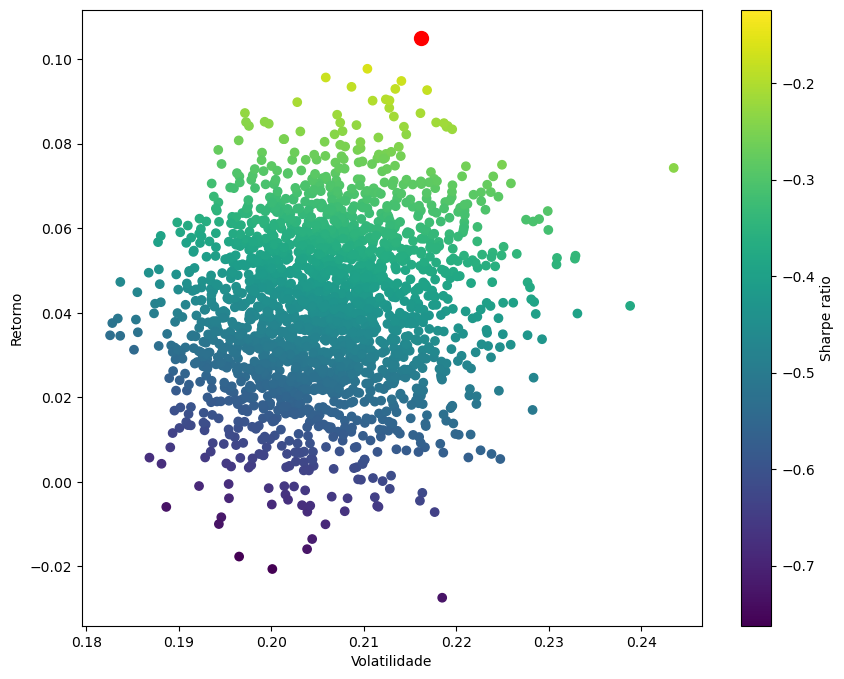

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(ls_volatilidade, ls_retorno, c = ls_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red', s = 100);

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=e2b9c116a3fcf3c64f49936446968c56e420ae311af8531bdcd87e3c2325ba65
  Stored in directory: /home/ikaro/.cache/pip/wheels/40/ff/aa/d5ea39ea054381b6eccc737df85530f8637e17f02517284f3f
Successfully built sklearn
